## Intro figure

In [1]:
import pandas as pd
from pathlib import Path
from datetime import datetime
from torch.utils.data import DataLoader
from amoc_reconstruction.reconstruction.model import init_assignment_module
from amoc_reconstruction.reconstruction.model import ProfileModelSUSTeR5_fast, ProfileModelSUSTeR6, ProfileModelSUSTeR7
from amoc_reconstruction.train import train, make_predictions
from amoc_reconstruction.reconstruction.dataset import merge_profiles_max_profiles
from amoc_reconstruction.reconstruction.dataset import load_merged_argo_dataset_and_tumo_cycles, filter_ds_argo_data, split_dataset_into_training_validation_testing_profile_datasets, load_merged_argo_dataset_and_tumo
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import torch
import cartopy.crs as ccrs 
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import xarray as xr

In [2]:
import os
data_base_path = Path(os.path.dirname(os.path.abspath("__file__"))) / '../../data_publication/datasets/'

def get_output_fig_path():
    notebook_dir = Path(os.path.dirname(os.path.abspath("__file__")))
    output_fig_path = notebook_dir / "../figures/"
    return output_fig_path

In [3]:
### PARAMETERS

smoothing_days = 90

time_smoothing = f'{smoothing_days}D'
lat_bounds = (25, 30)

target_reference_level = 4800



missing_values_in_target = False
using_missing_indices = False
using_transport_from_previous_year = False
use_deep_dvdz = False
deep_argo = True

geostrophic_prediction = False


train_batch_sizes = {
    '10D': 32,
    '30D': 16,
    '90D': 8,
    '365D': 4,
}


n_compartments_for_smoothing = {
    '10D': 49,
    '30D': 3,
    '90D': 9,
    '365D': 42,
}

train_batch_size = train_batch_sizes[time_smoothing]

add_tmp = False
add_sal = False

test_start_year = 2005
test_end_year = 2025

validation_years_on_each_side = 10


random_split_data = False

assert target_reference_level in [2000, 4800], "Only 2000 and 4800 are supported as reference levels"
version = 'v5'
n_compartments = n_compartments_for_smoothing[time_smoothing]
n_embedding = 8

distance_assignment_module  = 'distance'

dataset_path = data_base_path / Path( f'smoothing_{smoothing_days}_days/argo_after_2012/paperdraft/')
total_moc_path = data_base_path /  Path('moc_total/')
antilles_current_path = data_base_path /  Path('antilles_current/')
florida_current_path = data_base_path /  Path('florida_current/')
wind_stress_path = data_base_path /  Path('windstress/')

ref_folder = f'{abs(target_reference_level)}m_ref'

compartments = [
        ['west_p', -76.74, -70, 'west'],
        ['mar_west_p', -60, -47, 'east'],
        ['mar_east_p', -47, -40, 'west'],
        ['east_p', -30, -13.5, 'east']
    ]


device = 'cpu'


assert version in ['v2', 'v3', 'v4', 'v5']
assert distance_assignment_module in ['distance', 'fixed']



In [4]:
import numpy as np
# print([np.datetime64('1958-01-01') + t_delta[i] + np.timedelta64(365, 'D') for i in range(len(t_delta))])

In [5]:
ds_argo_merged_cycles_365D = []
t_umo_obs_cycles_365D = []
ds_pos_cycles_365D = []
dv_dz_cycles_365D = []
total_moc_cycles_365D = []
antilles_current_cycles_365D = []
florida_current_cycles_365D = []
wind_stress_cycles_365D = []

for suffix in   ['1st_7024', '2nd_5824', '3rd_5824', '4th_5824', '5th_5824', '6th_5824']:
    ds_argo_merged_cycle, t_umo_obs_cycle, ds_pos_cycle, dv_dz_cycle, total_moc_cycle, antilles_current_cycle, florida_current_cycle, wind_stress_cycle = load_merged_argo_dataset_and_tumo(
        '365D', 
        Path(f'../rapid-geostrophic-reconstruction/datasets/smoothing_365_days/argo_after_2012/paperdraft/'),
        ref_folder,
        total_moc_path,
        antilles_current_path,
        florida_current_path,
        wind_stress_path,
        missing_values_in_target= missing_values_in_target,
        suffix= suffix, 
        deep_argo = deep_argo
    )

    ds_argo_merged_cycles_365D.append(ds_argo_merged_cycle)
    t_umo_obs_cycles_365D.append(t_umo_obs_cycle)
    ds_pos_cycles_365D.append(ds_pos_cycle)
    dv_dz_cycles_365D.append(dv_dz_cycle)
    total_moc_cycles_365D.append(total_moc_cycle)
    antilles_current_cycles_365D.append(antilles_current_cycle)
    florida_current_cycles_365D.append(florida_current_cycle)
    wind_stress_cycles_365D.append(wind_stress_cycle)
    

FileNotFoundError: [Errno 2] No such file or directory: b'/gxfs_work/geomar/smomw507/geomar/paper_recons_amoc/paper_code/rapid-geostrophic-reconstruction/datasets/smoothing_365_days/argo_after_2012/paperdraft/ds_deep_argo_viking_KFS003-1st_7024.nc'

In [5]:
ds_argo_merged, t_umo_obs, ds_pos_sim, dv_dz_obs, t_delta, total_moc, antilles_current, florida_current, wind_stress, backwards_timeshift = load_merged_argo_dataset_and_tumo_cycles(
    ['1st_7024', '2nd_5824'],#, '3rd_5824', '4th_5824', '5th_5824', '6th_5824'],
    dataset_path,
    ref_folder,
    total_moc_path,
    antilles_current_path,
    florida_current_path,
    wind_stress_path,
    time_smoothing,
    deep_argo,
    missing_values_in_target
)


ds_argo_merged = filter_ds_argo_data(ds_argo_merged, False)



train_dataset, val_dataset, test_dataset, (total_moc_mean, total_moc_std, geostrophic_moc_mean, geostorphic_moc_std) = split_dataset_into_training_validation_testing_profile_datasets(
    False, test_start_year, test_end_year, validation_years_on_each_side, t_umo_obs, ds_argo_merged, add_tmp, add_sal, deep_argo, False, total_moc, florida_current, antilles_current, wind_stress, dv_dz_obs, missing_values_in_target, ds_pos_sim, compartments, time_smoothing, lat_bounds, using_transport_from_previous_year, using_missing_indices, use_deep_dvdz, backwards_timeshift
)


dl = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, collate_fn=merge_profiles_max_profiles, num_workers=0)
val_dl = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=merge_profiles_max_profiles, num_workers=0)
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=merge_profiles_max_profiles, num_workers=0)


/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


142 222 2005-03-28T00:00:00.000000000 2024-12-13T00:00:00.000000000
325 81 81


In [7]:
import pickle as pkl
with open(data_base_path / '../introduction_figure_support/mask_mesh_parts.pckl', 'rb') as f:
    mask_mesh_parts = pkl.load(f)

tmask_more_than_100x = mask_mesh_parts['tmask_more_than_100x']
nav_lons_at_265N = mask_mesh_parts['nav_lons_at_265N']
tmask_at_265N = mask_mesh_parts['tmask_at_265N']
z_layers = mask_mesh_parts['z_layers']

In [8]:
averaged_stream_function_both_cycles = xr.open_dataset(data_base_path / '../introduction_figure_support/averaged_stream_function_both_cycles.nc')

In [9]:
antilles_section = xr.open_dataarray(data_base_path / '../introduction_figure_support/antilles_section.nc')

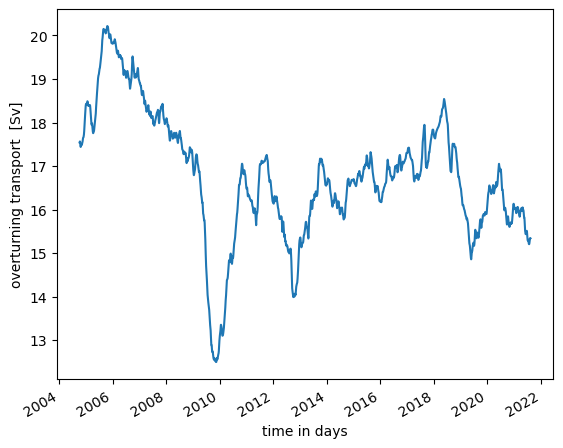

In [10]:
rapid_moc = xr.open_dataset(data_base_path / '../introduction_figure_support/moc_transports.nc')
rapid_moc = rapid_moc.rolling(time=2*365, center=True).mean()
rapid_moc.moc_mar_hc10.plot()


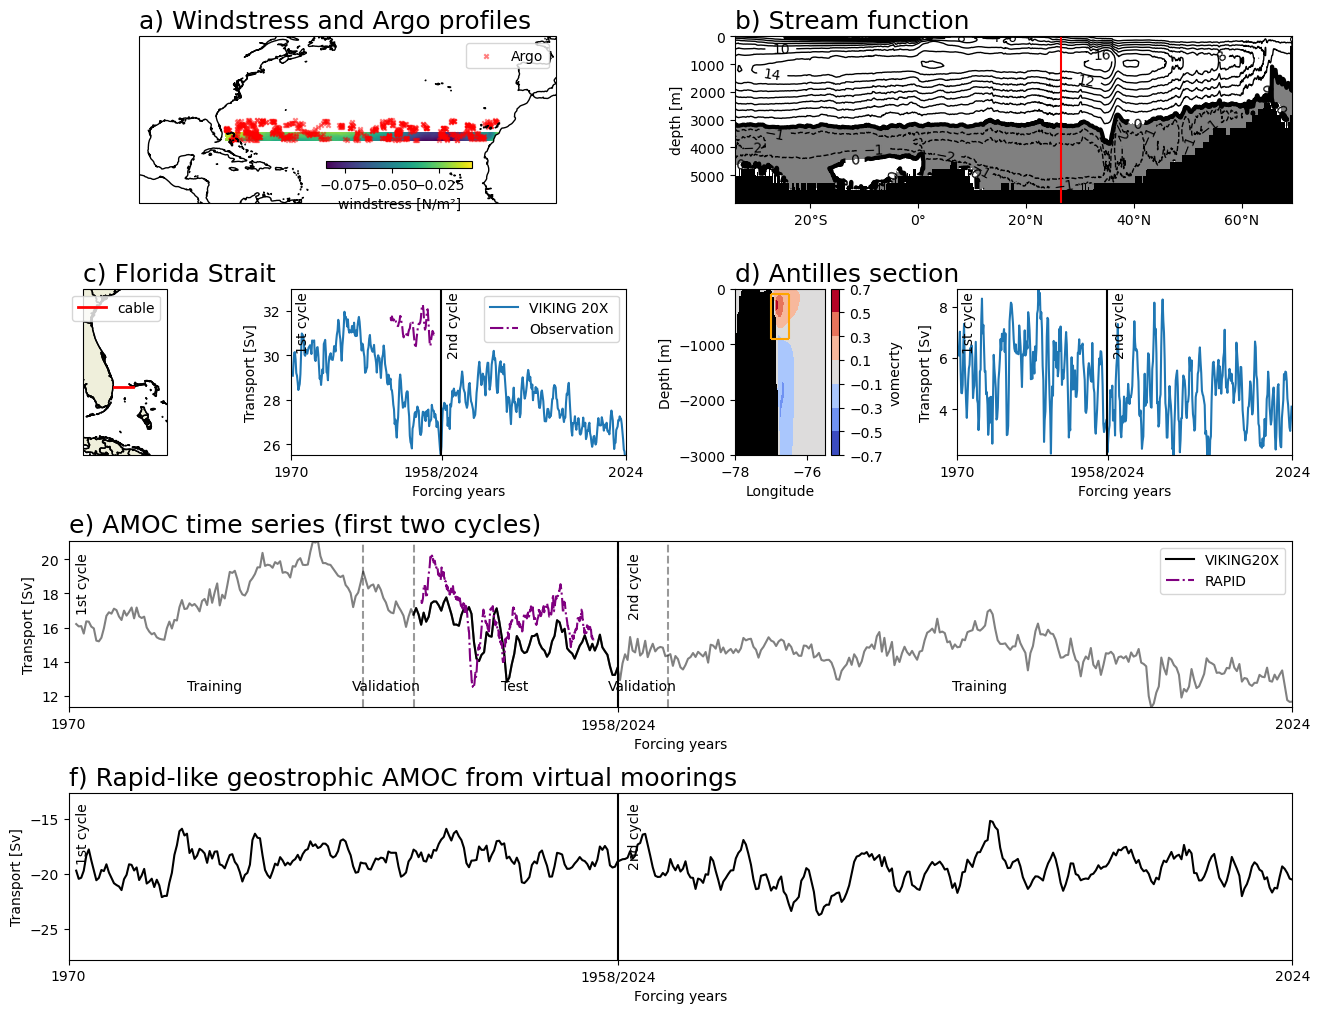

In [11]:
fig = plt.figure(figsize=(13.3,12.8 / 5 * 4 ))

ts = 110

axes = fig.subplot_mosaic(
    """
    AAABBB
    CDDEFF
    GGGGGG
    IIIIII
    """,
    per_subplot_kw = {
        'AC': {'projection': ccrs.PlateCarree()},
    }
)




## Windstress and Argos 
ax = axes['A']


windstress = xr.open_dataarray(data_base_path / 'windstress/sozotaux_2527N_8010W_KFS003-1st_7024.nc')
monthly_windstress = windstress.groupby(windstress.time_counter.dt.floor('30D')).mean().rename({'floor': 'time'})

monthly_windstress = monthly_windstress.isel(time = 550)
taux = ax.pcolormesh(monthly_windstress.nav_lon, monthly_windstress.nav_lat, monthly_windstress.values, transform=ccrs.PlateCarree(), cmap = 'viridis')






ax.scatter(
    ds_argo_merged.isel(time = ts).where(ds_argo_merged.isel(time = ts).profile_mask.sum('z') > 0, drop = True).lon.values,
    ds_argo_merged.isel(time = ts).where(ds_argo_merged.isel(time = ts).profile_mask.sum('z') > 0, drop = True).lat.values,
    transform = ccrs.PlateCarree(),
    marker='x', s = 10, color = 'red', alpha=.5, label = 'Argo'
)

ax.legend()

ax.set_extent([-100,0,10,50], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)

# cax = ax.inset_axes([0.05, 0.05, 0.9, 0.25], transform=ax.transAxes)
cax = ax.inset_axes([0.45, 0.21, 0.35, 0.04])
fig.colorbar(taux, cax = cax, label = 'windstress [N/m²]', orientation='horizontal')

ax.set_title('a) Windstress and Argo profiles', loc='left', fontsize = 18)


## Stream function
ax = axes['B']

stream_function = averaged_stream_function_both_cycles
ax.set_facecolor('black')
areas = ax.contourf(stream_function.squeeze().nav_lat, stream_function.squeeze().depthw, stream_function.squeeze().zomsfatl.where(tmask_more_than_100x), levels = 0, colors = ['grey', 'white'])


zero_contour = ax.contour(stream_function.squeeze().nav_lat, stream_function.squeeze().depthw, stream_function.squeeze().zomsfatl.where(tmask_more_than_100x), colors = 'black', levels = 0, linewidths = 3)

strike_contour = ax.contour(stream_function.squeeze().nav_lat, stream_function.squeeze().depthw, stream_function.squeeze().zomsfatl.where(tmask_more_than_100x), colors = 'black', levels = [-2, -1] + list(range(2, 20, 2)), linewidths = 1)


ax.clabel(strike_contour, strike_contour.levels, inline=True, fontsize=10)
ax.clabel(zero_contour, zero_contour.levels, inline=True, fontsize=10)

ax.set_ylabel('depth [m]')

ax.set_xticks([-20, 0, 20, 40, 60], ['20°S', '0°', '20°N', '40°N', '60°N'])

ax.set_yticks(np.arange(0, 6000, 1000) * -1,np.arange(0, 6000, 1000))

ax.vlines(26.5, -6000, 0, colors='red')
ax.set_ylim(-6000, 0)

ax.set_title('b) Stream function', loc='left', fontsize = 18)

## Florida strait map
ax = axes['C']

ax.plot([-80, -78.7], [26.5, 26.5], transform = ccrs.PlateCarree(), linewidth = 2, color = 'red')
ax.legend(['cable'])
plt.title('')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.STATES)
ax.set_extent((-82, -76.5, 22, 33))
ax.set_title('c) Florida Strait', loc='left', fontsize = 18)




##Florida strait time series
ax = axes['D']

# (florida_current.sobarstf / 1e6).groupby(florida_current['time'].dt.round('365D')).mean().rename({'round': 'time'}).plot(ax = ax, label = 'VIKING 20X')
smoothed_florida = (florida_current.sobarstf / 1e6).rolling(time = 4, center = True).mean()
smoothed_florida.plot(ax = ax, label = 'VIKING 20X')
# florida_obs = xr.open_dataset('data/observations/florida.nc').__xarray_dataarray_variable__
# florida_obs = florida_obs.groupby(florida_obs['time'].dt.round('365D')).mean().rename({'round': 'time'})
# florida_obs.plot(ax = ax, label = 'Observation')

rapid_moc.t_gs10.resample(time = '90D').mean().rolling(time = 4).mean().plot(ax = ax, label = 'Observation',c = 'purple', linestyle = '-.',)

ax.vlines(smoothed_florida.time.sel(time = '2024-01-01', method = 'nearest'), 25.5,33, color = 'k', linestyle = '-')
ax.set_ylim(25.5, 33)
ax.set_xlim(smoothed_florida.time.min().data, smoothed_florida.time.max().data)
ax.text(smoothed_florida.time.sel(time = '1972-01-01', method = 'nearest'), 32.9, '1st cycle', rotation=90, verticalalignment = 'top')
ax.text(smoothed_florida.time.sel(time = '2026-01-01', method = 'nearest'), 32.9, '2nd cycle', rotation=90, verticalalignment = 'top')

# set x tickslabels 01-01-1970 to 1970, '01-01-2024' to '1958/2024'
ax.set_xticks([np.datetime64('1970-01-01'), np.datetime64('2024-01-01'), np.datetime64('2090-01-01')], ['1970', '1958/2024', '2024'], rotation = 'horizontal')

for label in ax.get_xticklabels():
    label.set_horizontalalignment('center')

ax.set_ylabel('Transport [Sv]')
ax.set_xlabel('Forcing years')
ax.legend()


## Antilles depth section
ax = axes['E']


antilles_section.plot.contourf(x = 'nav_lon', y = 'z', ax = ax, levels = [-.7,-.5, -.3, -.1, .1, .3, .5, .7], cmap = 'coolwarm')

ax.set_facecolor('black')


# ax.vlines(-75.5,-5000,0, color = 'black')
# ax.vlines(-76.74,-5000,0, color = 'black')


ax.vlines(-77,-900,-100, color = 'orange')
ax.vlines(-76.5,-900,-100, color = 'orange')
ax.hlines(-900, -77, -76.5, color = 'orange')
ax.hlines(-100, -77, -76.5, color = 'orange')

ax.set_xlim(-78, -75.5)
ax.set_ylim(-3000, 0)
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Longitude')

ax.set_title('d) Antilles section', loc='left', fontsize = 18)


## Antilles time series
ax = axes['F']

smoothed_antilles = (antilles_current.__xarray_dataarray_variable__ ).rolling(time = 4, center = True).mean() #.groupby(antilles_current['time'].dt.round('365D')).mean().rename({'round': 'time'})
smoothed_antilles.plot(ax = ax)

ax.set_xticks([np.datetime64('1970-04-01'), np.datetime64('2024-01-01'), np.datetime64('2090-01-01')], ['1970', '1958/2024', '2024'], rotation = 'horizontal')

for label in ax.get_xticklabels():
    label.set_horizontalalignment('center')

ax.set_ylabel('Transport [Sv]')
ax.set_xlabel('Forcing years')

ax.vlines(smoothed_antilles.time.sel(time = '2024-01-01', method = 'nearest'), 2.2, 8.7, color = 'k', linestyle = '-')
ax.set_ylim(2.2, 8.7)
ax.set_xlim(smoothed_florida.time.min().data, smoothed_antilles.time.max().data)
ax.text(smoothed_antilles.time.sel(time = '1972-01-01', method = 'nearest'), 8.6, '1st cycle', rotation=90, verticalalignment = 'top')
ax.text(smoothed_antilles.time.sel(time = '2026-01-01', method = 'nearest'), 8.6, '2nd cycle', rotation=90, verticalalignment = 'top')


## AMOC time series with train, val, and test
ax = axes['G']

moc_series = total_moc.zomsfatl.sel(depthw = -1000, method = 'nearest')
moc_series = moc_series.rolling(time = 4).mean() #.groupby(moc_series.time.dt.round('365D')).mean().rename({'round': 'time'})

test_indices = moc_series.assign_coords(ti = ('time', np.arange(len(moc_series.time)))).sel(time = slice('2004-01-01', '2024-01-01')).ti.values
valid_indices_1 =  moc_series.assign_coords(ti = ('time', np.arange(len(moc_series.time)))).sel(time = slice('1999-01-01', '2004-01-01')).ti.values
valid_indices_2 =  moc_series.assign_coords(ti = ('time', np.arange(len(moc_series.time)))).sel(time = slice('2024-01-01','2029-01-01')).ti.values
val_indices = np.concatenate([valid_indices_1, valid_indices_2])





train_mask = ~np.isin(np.arange(moc_series.time.shape[0]), np.concatenate((val_indices, test_indices)))
train_indices = np.arange(moc_series.time.shape[0])[train_mask]

ax.plot(moc_series.time, moc_series.values, c = 'grey')

ax.vlines(moc_series.time[test_indices[0]], moc_series.min().data, moc_series.max().data, color = 'k', linestyle = '--', alpha= .4)
ax.vlines(moc_series.time[test_indices[-1]], moc_series.min().data, moc_series.max().data, color = 'k', linestyle = '--', alpha= .4)
ax.vlines(moc_series.time[val_indices[0]], moc_series.min().data, moc_series.max().data, color = 'k', linestyle = '--', alpha= .4)
ax.vlines(moc_series.time[val_indices[-1]], moc_series.min().data, moc_series.max().data, color = 'k', linestyle = '--', alpha= .4)


ax.vlines(moc_series.time.sel(time = '2024-01-01', method = 'nearest'), moc_series.min().data, moc_series.max().data, color = 'k', linestyle = '-')
ax.text(moc_series.time.sel(time = '1971-01-01', method = 'nearest'), 20.4, '1st cycle', rotation=90, verticalalignment = 'top')
ax.text(moc_series.time.sel(time = '2025-01-01', method = 'nearest'), 20.4, '2nd cycle', rotation=90, verticalalignment = 'top')


ax.set_xticks([np.datetime64('1970-04-01'), np.datetime64('2024-01-01'), np.datetime64('2090-01-01')], ['1970', '1958/2024', '2024'], rotation = 'horizontal')

ax.text(moc_series.time[int(test_indices.mean())], moc_series.min().data + 1, 'Test', ha = 'center')
ax.text(moc_series.time[int(val_indices[val_indices < val_indices[np.argmax(np.diff(val_indices))] + (np.diff(val_indices).max() // 2) ].mean())], moc_series.min().data + 1, 'Validation', ha = 'center')
ax.text(moc_series.time[int(val_indices[val_indices > val_indices[np.argmax(np.diff(val_indices))] + (np.diff(val_indices).max() // 2) ].mean())], moc_series.min().data + 1, 'Validation', ha = 'center')
ax.text(moc_series.time[int(train_indices[train_indices <= train_indices[np.argmax(np.diff(train_indices))] + (np.diff(train_indices).max() // 2) ].mean())], moc_series.min().data + 1, 'Training', ha = 'center')
ax.text(moc_series.time[int(train_indices[train_indices > train_indices[np.argmax(np.diff(train_indices))] + (np.diff(train_indices).max() // 2)].mean())], moc_series.min().data + 1, 'Training', ha = 'center')

test = moc_series.isel(time = test_indices)
ax.plot(test.time, test.values, c = 'k', label = 'VIKING20X', alpha = 1)

ax.plot(rapid_moc.time, rapid_moc.moc_mar_hc10.values, c = 'purple', linestyle = '-.', label = 'RAPID')
ax.legend()
ax.set_xlim(moc_series.time.min().data, moc_series.time.max().data)
ax.set_ylim(moc_series.min().data, moc_series.max().data)
# ax.set_xticklabels([])
# ax.set_title('VIKING20X (1st and 2nd cycle)')
ax.set_ylabel('Transport [Sv]')
ax.set_title('e) AMOC time series (first two cycles)', loc='left', fontsize = 18)
ax.set_xlabel('Forcing years')



ax = axes['I']

# t_umo_obs.dv_dz_times_X.plot(ax = ax, c = 'k', linestyle = '-', label = 'RAPID-like (geos.)') 
ax.plot(t_umo_obs.time, t_umo_obs.dv_dz_times_X.rolling(time = 4).mean().values, c = 'k', label = 'VIKING20X (geos.)', alpha = 1)
ax.vlines(moc_series.time.sel(time = '2024-01-01', method = 'nearest'), t_umo_obs.dv_dz_times_X.min().data, t_umo_obs.dv_dz_times_X.max().data, color = 'k', linestyle = '-')
ax.text(moc_series.time.sel(time = '1971-01-01', method = 'nearest'), -13.5, '1st cycle', rotation=90, verticalalignment = 'top')
ax.text(moc_series.time.sel(time = '2025-01-01', method = 'nearest'), -13.5, '2nd cycle', rotation=90, verticalalignment = 'top')


ax.set_xlim(moc_series.time.min().data, moc_series.time.max().data)

ax.set_ylabel('Transport [Sv]')
ax.set_xlabel('Forcing years')
ax.set_ylim(t_umo_obs.dv_dz_times_X.min().data,t_umo_obs.dv_dz_times_X.max().data)
ax.set_xticks([np.datetime64('1970-04-01'), np.datetime64('2024-01-01'), np.datetime64('2090-01-01')], ['1970', '1958/2024', '2024'], rotation = 'horizontal')
ax.set_title('f) Rapid-like geostrophic AMOC from virtual moorings', loc='left', fontsize = 18)

fig.tight_layout()
plt.savefig(get_output_fig_path() / '01_overview.png', dpi = 300)

NameError: name 'total_moc_cycles_365D' is not defined

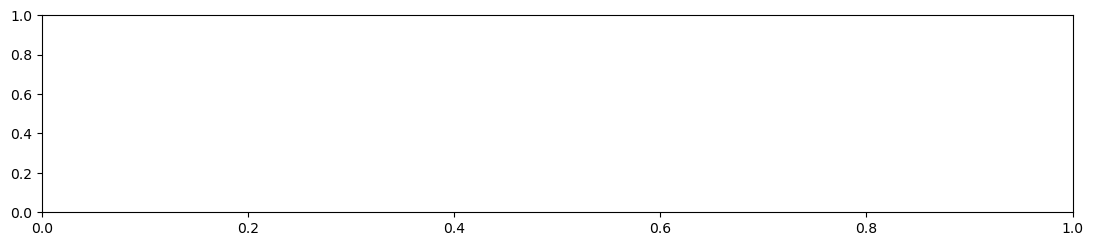

In [12]:
fig = plt.figure(figsize=(13.3,12.8 / 5 * 1 ))
ax = fig.add_subplot(1,1,1)




time_series = []
time_series_counts = []
for tot_moc_i in total_moc_cycles_365D:
    values = tot_moc_i.zomsfatl.sel(depthw = -1000, method = 'nearest').values.tolist()
    time_series.extend(values)
    time_series_counts.append(len(values))


xr.DataArray(time_series).rolling(dim_0 = 10, center = True).mean().plot(ax = ax, label = 'VIKING20X', alpha = 1)

# ax.plot(np.arange(len(time_series)), time_series, c = 'grey')

ax.set_xlim(0, len(time_series))
ax.set_ylabel('Transport [Sv]')
ax.set_xlabel('Forcing years')
ax.set_ylim(10,20)




def map_name(cycle):
    if cycle == 0:
        return '1st cycle'
    elif cycle == 1:
        return '2nd cycle'
    elif cycle == 2:
        return '3rd cycle'
    elif cycle == 3:
        return '4th cycle'
    elif cycle == 4:
        return '5th cycle'
    elif cycle == 5:
        return '6th cycle'
    else:
        raise ValueError('Cycle not found')

for i in range(len(time_series_counts)):
    ax.vlines(np.sum(time_series_counts[:i]), 10, 20, color = 'k', linestyle = '-', alpha= 1)
    ax.text(np.sum(time_series_counts[:i])+5, 19.8, map_name(i), rotation=90, verticalalignment = 'top')

def map_ticks_name_6cycles(i):
    if i == 0: return '1970'
    elif i == len(time_series_counts): return '2024'
    else: return '1958/2024'

ax.set_xticks(np.cumsum([0] + time_series_counts), [map_ticks_name_6cycles(i) for i in range(len(time_series_counts) + 1)], rotation = 'horizontal')

# ax.set_title('g) AMOC time series (all six cycles)', loc='left', fontsize = 18)

plt.savefig(get_output_fig_path() / '06a_all_cycles_transport.png', dpi = 300)

(-6000.0, 0.0)

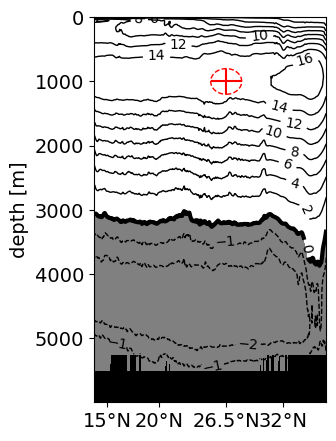

In [13]:
# set font size to 16
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(3,5))
ax = fig.add_subplot(1,1,1)
stream_function = averaged_stream_function_both_cycles.isel(y = slice(1000,1500))
tmask_more_than_100x_sliced = tmask_more_than_100x.isel(y = slice(1000,1500))
ax.set_facecolor('black')
areas = ax.contourf(stream_function.squeeze().nav_lat, stream_function.squeeze().depthw, stream_function.squeeze().zomsfatl.where(tmask_more_than_100x_sliced), levels = 0, colors = ['grey', 'white'])


zero_contour = ax.contour(stream_function.squeeze().nav_lat, stream_function.squeeze().depthw, stream_function.squeeze().zomsfatl.where(tmask_more_than_100x_sliced), colors = 'black', levels = 0, linewidths = 3)

strike_contour = ax.contour(stream_function.squeeze().nav_lat, stream_function.squeeze().depthw, stream_function.squeeze().zomsfatl.where(tmask_more_than_100x_sliced), colors = 'black', levels = [-2, -1] + list(range(2, 20, 2)), linewidths = 1)


ax.clabel(strike_contour, strike_contour.levels, inline=True, fontsize=10)
ax.clabel(zero_contour, zero_contour.levels, inline=True, fontsize=10)

ax.set_ylabel('depth [m]')

ax.set_xticks([-20, 15, 20, 26.5, 32, 60], ['20°S', '15°N', '20°N', '26.5°N', '32°N', '60°N'])

ax.set_yticks(np.arange(0, 6000, 1000) * -1,np.arange(0, 6000, 1000))

ax.vlines(26.5, -1200, -800, colors='red')
ax.hlines(-1000, 25, 28, colors='red')

from matplotlib.patches import Circle, Ellipse

ax.add_patch(Ellipse((26.5, -1000), 3, 400, alpha=1, facecolor ='none', edgecolor = 'red', linestyle = '--'))
ax.set_ylim(-6000, 0)

# ax.set_title('b) Stream function', loc='left', fontsize = 18)

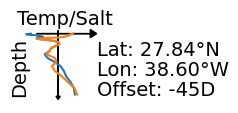

In [14]:

# indices (0, 5), (50,46)
#50,2
# 0, 53
index_time = 50
index_pos = 2
pos_save = 1

from mpl_toolkits.axisartist.axislines import SubplotZero
fig = plt.figure(figsize=(1, 1))
ax = SubplotZero(fig, 111)
fig.add_subplot(ax)

(((ds_argo_merged -ds_argo_merged.temperature.isel(time = index_time).mean(['pos'])) / ds_argo_merged.temperature.isel(time = index_time).std(['pos']))).isel(time = index_time, pos = index_pos).sel(z = slice(-2000, None)).temperature.plot( y = 'z', ax = ax)
(((ds_argo_merged - ds_argo_merged.salinity.isel(time = index_time).mean(['pos'])) / ds_argo_merged.salinity.isel(time = index_time).std(['pos']))).isel(time = index_time, pos = index_pos).sel(z = slice(-2000, None)).salinity.plot( y = 'z', ax = ax)



ax.set_title(None)
ax.set_ylabel('Depth [m]')

# ax.axis['xzero'].set_axisline_style("-|>")
# ax.axis['xzero'].set_visible(True)



for direction in ["left", "right", "bottom", "top"]:
    # hides borders
    ax.axis[direction].set_visible(False)

# ax.axis['left'].set_axisline_style("-|>")
# ax.axis['left'].set_visible(True)


ax.arrow(0, 100, 0, -2000, head_width=.2, head_length=100, fc='k', ec='k')
ax.arrow(-1, 0, 2.5, 0, head_width=250, head_length=.3, fc='k', ec='k')

ax.text(0.3, 450, 'Temp/Salt', verticalalignment = 'center', horizontalalignment = 'center')
ax.text(-1.8, -1000, 'Depth',rotation = 90,  verticalalignment = 'center', horizontalalignment = 'center')

ax.text(1.8, -500, f'Lat: {ds_argo_merged.isel(time = index_time, pos = index_pos).lat.values[()]:.2f}°N', verticalalignment = 'center', horizontalalignment = 'left')
ax.text(1.8, -1100, f'Lon: {-ds_argo_merged.isel(time = index_time, pos = index_pos).lon.values[()]:.2f}°W', verticalalignment = 'center', horizontalalignment = 'left')
ax.text(1.8, -1700, f'Offset: {(ds_argo_merged.isel(time = index_time, pos = index_pos).time_1d - ds_argo_merged.isel(time = index_time, pos = index_pos).time).values.astype("timedelta64[D]").astype(int)}D', verticalalignment = 'center', horizontalalignment = 'left')

# fig.tight_layout()

plt.savefig(get_output_fig_path() / f'profile_{pos_save:02d}.png', dpi = 300,bbox_inches='tight')

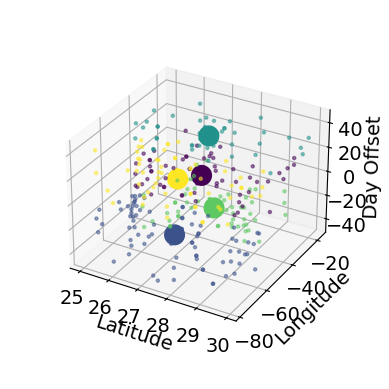

In [15]:
from mpl_toolkits.mplot3d import Axes3D

temporal_index = 56

import matplotlib.pyplot as plt
# Assuming you have latitudes, longitudes, and day offset data
latitudes = ds_argo_merged.isel(time = temporal_index).lat
longitudes = ds_argo_merged.isel(time = temporal_index).lon
day_offset = (ds_argo_merged.isel(time = temporal_index).time_1d - ds_argo_merged.isel(time = temporal_index).time).values.astype("timedelta64[D]").astype(int)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
valid_mask = day_offset > -1000
# ax.scatter(latitudes[valid_mask], longitudes[valid_mask], day_offset[valid_mask])

ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Day Offset')


from sklearn.cluster import KMeans  

kmeans = KMeans(n_clusters=5)

X = np.array([latitudes[valid_mask], longitudes[valid_mask], day_offset[valid_mask]]).T

kmeans.fit(X)

y_kmeans = kmeans.predict(X)

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_kmeans, s=5, cmap='viridis', alpha = .5)


centers = kmeans.cluster_centers_

ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2],c = np.arange(5), cmap='viridis', s=200, alpha=1)

# fig.tight_layout()

# zoom out to see the z label
ax.set_box_aspect(aspect=None, zoom=0.8)
# Make a 3 dimensional plot of latitudes, longitudes, and day offset

plt.savefig(get_output_fig_path() / f'cluster_{index_time}.png', dpi = 300,bbox_inches='tight')


In [16]:
mooring_ds = xr.open_dataset(data_base_path / 'mooring_data/mooring_data_1st_7024.nc')
mooring_ds = mooring_ds.groupby(mooring_ds.time_counter.dt.floor(time_smoothing)).mean().rename({'floor': 'time'})
mooring_ds = mooring_ds.where(mooring_ds.votemper > 0)


import gsw
mooring_ds["ct"] = gsw.conversions.CT_from_pt(mooring_ds.sel(variable = 'salt').votemper, mooring_ds.sel(variable = 'temp').votemper)
mooring_ds["ct"].attrs["long_name"] = "Conservative Temperature"
mooring_ds["ct"].attrs["units"] = "degC"
mooring_ds["rho"] = gsw.density.rho(mooring_ds.sel(variable = 'salt').votemper, mooring_ds.ct, mooring_ds.deptht)
mooring_ds["rho"].attrs["long_name"] = "Density"
mooring_ds["rho"].attrs["units"] = "kg/m3"


In [17]:
ts = 110


lon_bins = nav_lons_at_265N
indices = np.abs(ds_argo_merged.isel(time = ts).dropna('pos').lon.values.reshape(-1,1) - lon_bins.reshape(1, -1)).argmin(axis = -1)

nan_image = np.full(shape = (lon_bins.shape[0], 46), fill_value=np.nan)
nan_image[indices, :29] = ds_argo_merged.isel(time = ts).dropna('pos').rho.values



indices = np.abs(mooring_ds.isel(time = ts).nav_lon.values.reshape(-1,1) - lon_bins.reshape(1, -1)).argmin(axis = -1)
nan_image[indices] = mooring_ds.isel(time = ts).rho.values.T


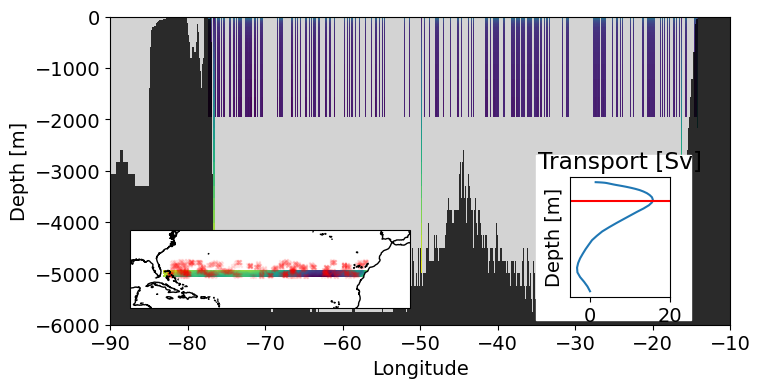

In [18]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1,1,1)

# set the background color of the plot to white
ax.set_facecolor('lightgrey')

bottom = tmask_at_265N
bottom[bottom == 1] = np.NaN

rho = ax.pcolormesh(lon_bins, z_layers, nan_image.T, cmap = 'viridis')
ax.pcolormesh(lon_bins, z_layers, bottom, cmap = 'grey', alpha=.8)


# plt.colorbar(rho, ax = ax, label = 'Density')
ax.set_xlabel('Longitude')
ax.set_ylabel('Depth [m]')
ax.set_xlim(-90, -10)

# ax.set_title(f'{np.datetime_as_string(ds_argo_merged_10days.time[ts].values[()], unit="D")} - {np.datetime_as_string(ds_argo_merged_10days.time[ts+1].values[()], unit="D")}')


# for m in mooring_ds.moorings:
#     plt.text(m.nav_lon.values[()],100, m.values)

from cartopy import crs as ccrs
from cartopy import feature as cfeature


ax_inner = plt.axes([0.15, 0, .35, 0.5], projection=ccrs.PlateCarree(), transform = ax.transAxes, label='2')


# ax_inner = ax.inset_axes(
#     [0.1, 0.1, 0.1, 0.1], 
#     projection=ccrs.PlateCarree(),
#     transform=ax.transAxes, facecolor='white')

ax_inner.set_extent([-90,0,15,40], crs=ccrs.PlateCarree())

windstress = xr.open_dataarray(data_base_path / 'windstress/sozotaux_2527N_8010W_KFS003-1st_7024.nc')
monthly_windstress = windstress.groupby(windstress.time_counter.dt.floor('30D')).mean().rename({'floor': 'time'})

monthly_windstress = monthly_windstress.isel(time = 550)
taux = ax_inner.pcolormesh(monthly_windstress.nav_lon, monthly_windstress.nav_lat, monthly_windstress.values, transform=ccrs.PlateCarree(), cmap = 'viridis')

ax_inner.scatter(
    ds_argo_merged.isel(time = ts).dropna('pos').lon.values,
    ds_argo_merged.isel(time = ts).dropna('pos').lat.values,
    transform = ccrs.PlateCarree(),
    marker='x', s = 10, color = 'red', alpha=.1
)


ax_inner.add_feature(cfeature.COASTLINE)



# create rectangular patch 

from matplotlib.patches import Rectangle

# Create a Rectangle patch
rect = Rectangle((-35, -5900), 20, 3200, linewidth=1, edgecolor='white', facecolor='white')

# Add the patch to the Axes
ax.add_patch(rect)





ax_inner_moc = plt.axes([0.7, 0.18, .125, 0.3])
total_moc.zomsfatl.mean('time').plot(y = 'depthw', ax = ax_inner_moc)

ax_inner_moc.set_yticks([])
ax_inner_moc.set_ylabel('Depth [m]')
ax_inner_moc.set_xlabel(None)
ax_inner_moc.set_title('Transport [Sv]')

ax_inner_moc.set_xlim(-5, 20)

ax_inner_moc.hlines(-1000, -5, 20, color = 'red')


plt.savefig(get_output_fig_path()/ 'B_argo_profile.png', dpi = 300)

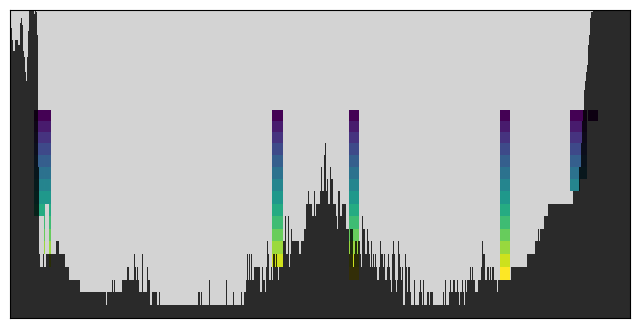

In [20]:
ts = 110


lon_bins = nav_lons_at_265N

indices = np.abs(ds_argo_merged.isel(time = ts).dropna('pos').lon.values.reshape(-1,1) - lon_bins.reshape(1, -1)).argmin(axis = -1)

nan_image = np.full(shape = (lon_bins.shape[0], 46), fill_value=np.nan)

indices = np.abs(mooring_ds.isel(time = ts).nav_lon.values.reshape(-1,1) - lon_bins.reshape(1, -1)).argmin(axis = -1)
values = mooring_ds.isel(time = ts).rho.values.T[..., 29:]
indices[0] += 12
indices[1] += 12
width = 11
for i in range(-width, width +1 ):
    nan_image[indices + i, 29:] = values

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1,1,1)

# set the background color of the plot to white
ax.set_facecolor('lightgrey')

bottom = tmask_at_265N

bottom[bottom == 1] = np.NaN

rho = ax.pcolormesh(lon_bins, z_layers, nan_image.T, cmap = 'viridis')
ax.pcolormesh(lon_bins, z_layers, bottom, cmap = 'grey', alpha=.8)


ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(-80, -10)


plt.savefig(get_output_fig_path() / 'mooring_icon.png', dpi = 300)